# Raytracing

The goal of this worksheet is for you to write a simple raytracer. That is, a program that takes a 3D model and generates an image of what it looks like from a particular camera angle (this is called _rendering_). In this case the 3D model will be represented by a _signed distance function_, which makes rendering particularly easy.

The purpose of this worksheet is to learn to __vectorise__ your code. As such, not only do you not need to know how raytracing works, but the _answer is provided_. The challenge is that the answer is provided as unvectorised per-pixel code, and you only get marks for a vectorised implementation.

## Marking and submission

These lab exercises are marked, and contribute to your final grade. This lab exercise has 20 marks to earn, equivalent to 10% of your final grade. Most of the time where you have to add code is indicated by

`# **************************************************************** 2 marks`

with instructions above the code block. Occasionally a markdown block will request that you return to an early block and edit it. There will be no indicator in such cases.

Please submit your completed workbook to the auto marker before 8th November, 20:00 GMT. The workbook you submit must be an .ipynb file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (`Save and checkpoint` in the `File` menu, the icon of a floppy disk, or `Ctrl-S`). It is wise to verify it runs to completion with _Restart & Run All_ before submission.

You must comply with the universities plagiarism guidelines: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

## Raytracing with Ray Marching

Real light gets emitted from a light source and then bounces from surface to surface around the world. Some of it may hit a camera, where it is absorbed and generates an electrical current, which is interpreted as an image. For instance, a ray of light may be emitted from the sun, hurtle across the vacume for 8 minutes and 19 seconds before descending through the atmosphere to strike a kitten on the head. The light then bounces off the kittens hair and into a camera, just so you can waste your time looking at cute cat images on the internet (Note: It's actually far more complicated than this. For one thing most 'bounces' are actually the light being absorbed then emitted again.).

Raytracing simulates this, but backwards for efficiency. We don't care about rays that never strike the camera. For the purpose of this exercise we are only going to simulate a single step. Our output image is a 2D grid of pixels. For each pixel a ray is fired out towards the scene. It will either miss all of the geometry and fly towards infinity, or it will strike the surface of an object. We can then measure the length of the ray and output a _depth map_, an image colour coded with the depth of each pixel.

Each ray is represented by three pieces of information:
 * It's starting location, a coordinate (length 3 vector). In effect, the location of the pixel on the sensor inside the virtual camera.
 * It's direction of travel, a normal, that is a length 3 vector with unit length.
 * How far it has travelled, a scalar.
 
This means we can work out where the end of the ray is as

`end = start + travel * normal`

The main challenge of raytracing is _collision detection_, that is detecting how far a ray can travel before it collides with a surface. Computer games mostly cheat, for speed; rendering for film vfx uses ray/triangle interactions with dense 3D geometry, combined with complex data structures for speed. We're going to do something completely different, that is most commonly used to optimise collision detection in physics simulations rather than rendering. A __signed distance function__ (sdf) tells you for every location how far you are from a surface. Imagine placing a sphere at the end of a ray and making it as large as possible before it touches the surface of an object. Its radius is the distance returned by the _sdf_ at the end of the ray. The distance is positive if you're outside an object, but negated if you're inside an object; the surface of an object in a _sdf_ is hence the _isosurface_ or _level set_ with value zero.

To collide a ray with a _sdf_ you repeat a simple process: evaluate the sdf at the current end point of the ray then move that far. If the ray is fired directly at the surface you will immediately collide, and the next time you evaluate the _sdf_ you will get $0$, and stop moving. Normally rays make glancing blows, and over many iterations get a little closer each time, until they stop moving on the surface of the object. This is the _ray marching algorithm_.

There are many ways to represent a _sdf_. The _sdf_ for a sphere is entirely analytic for instance - just the distance from the centre minus the radius. In this case we will be using _voxels_, quite simply a 3D array representing space, so indexed with 3D coordinates `[x,y,z]`, where the _sdf_ has been evaluated and stored in every cell. One has been provided on moodle (as a .hdf5 file) for you to download and render.

Here is an alternate explanation: http://jamie-wong.com/2016/07/15/ray-marching-signed-distance-functions/ (There are a couple cool videos showing how far this idea can be pushed, plus a more visual explanation; goes far beyond the below however)

## Imports

As you have seen before. h5py allows hdf5 files to be loaded, so you have a signed distance function to render.

In [1]:
%matplotlib inline

import numpy
import h5py # Feature rich library for reading/writing hdf5 files (designed for storing large nD arrays).
import matplotlib.pyplot as plt

## Setup

It's typical to have a block at the start of a Jupyter workbook to set some parameters. Here we have the resolution of the output image (1024 X 429 is half of DCI 2K Cinemascope, one of the standards for displaying films) and the _field of view_ (fov), which is a standard way of specifying how wide/zoomed in a camera lens is. 24mm is a fairly wide angle lens - this is a good choice for a distance map as we can't see the surface, only depth, which is exaggerated by a wide lens.

In addition the hdf5 file is loaded and the sdf function extracted as a numpy array. There are a number of sdf function files provided; feel free to try them all out ('Restart and Run All' in the kernel menu can be useful for this). It's wise to keep the below setup until you have a working system however and submit with the dragon enabled.

In [2]:
# Parameters...
width = 1024
height = 429

fov = 24.0 # Field of view in mm, 35mm equivalent.


# Load signed distance function...
with h5py.File('dragon.hdf5', 'r') as f:
    sdf = numpy.array(f['sdf'])

print('sdf shape =', sdf.shape)

sdf shape = (57, 90, 128)


## Start of Rays

Coordinates on a computer are represented at (x, y, z), but when images are stored in arrays they are indexed (y, x). This is more than a little confusing, but the convention we will be using for consistency with everyone else.

Your first task is to define the _start_ and _normal_ of each pixel in the image. The x values are stored in `start[:,:,0]`, the y values in `start[:,:,1]` and the z values in `start[:,:,2]`.
The code you need to vectorise is (`u` is the x coordinate in the image, `v` the y coordinate, to avoid confusion with the 3D coordinates being written):
```
for v in range(height):
  for u in range(width):
    start[v,u,0] = -0.5 + u / (width-1)
    start[v,u,1] = (-0.5 + v / (height-1)) * height / width
    start[v,u,2] = 0
```

In effect, these are the coordinates of the pixels on the virtual charged coupled device that is the imaging sensor. The slickest solution makes use of [`numpy.linspace()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) (clickable link to numpy help). Remember that you only get marks for a vectorised solution!

__(2 marks)__

In [3]:
# Starting position of each ray...
start = numpy.zeros((height, width, 3))

#  print(numpy.shape(a), numpy.shape(b), numpy.shape(start))

a = numpy.linspace(0,width-1,width)
u =(-0.5 + a/(width-1))


b = numpy.linspace(0,height-1,height)
ratio = height / width
v = ((-0.5 + b/(height-1))*ratio).reshape(429,1)

#  print(numpy.shape(u), numpy.shape(v), numpy.shape(start))

start[:,:,0] = u
start[:,:,1] = v
start[:,:,2] = 0
print(start)


# for v in range(height):
#   for u in range(width):
#     start[v,u,0] = -0.5 + u / (width-1)
#     start[v,u,1] = (-0.5 + v / (height-1)) * height / width
#     start[v,u,2] = 0
# print(start)

start2=start.copy()

   
    


# **************************************************************** (2 marks)


[[[-0.5        -0.20947266  0.        ]
  [-0.49902248 -0.20947266  0.        ]
  [-0.49804497 -0.20947266  0.        ]
  ...
  [ 0.49804497 -0.20947266  0.        ]
  [ 0.49902248 -0.20947266  0.        ]
  [ 0.5        -0.20947266  0.        ]]

 [[-0.5        -0.20849381  0.        ]
  [-0.49902248 -0.20849381  0.        ]
  [-0.49804497 -0.20849381  0.        ]
  ...
  [ 0.49804497 -0.20849381  0.        ]
  [ 0.49902248 -0.20849381  0.        ]
  [ 0.5        -0.20849381  0.        ]]

 [[-0.5        -0.20751497  0.        ]
  [-0.49902248 -0.20751497  0.        ]
  [-0.49804497 -0.20751497  0.        ]
  ...
  [ 0.49804497 -0.20751497  0.        ]
  [ 0.49902248 -0.20751497  0.        ]
  [ 0.5        -0.20751497  0.        ]]

 ...

 [[-0.5         0.20751497  0.        ]
  [-0.49902248  0.20751497  0.        ]
  [-0.49804497  0.20751497  0.        ]
  ...
  [ 0.49804497  0.20751497  0.        ]
  [ 0.49902248  0.20751497  0.        ]
  [ 0.5         0.20751497  0.        ]]

 [

## Direction of Rays

The normal of a pixel is the unit length vector from the origin of the camera through the pixel. In this case the origin is:

`origin = (0, 0, -fov / 36.0)`

(If you're wondering where the 36 came from, the fov is given relative to 35mm film, which is 35mm high _including the notches_, with 24mm allocated for the height of each image. The images themselves are then 36mm across.)

The direction for each pixel is `direction = start - origin`. This needs to be normalised, that is the direction vector has to be divided by it's length, which may be calculated as

`length = numpy.sqrt(numpy.square(direction).sum())`

To be super explicit, the full code without vectorisation looks like:
```
for v in range(height):
  for u in range(width):
    len_sqr = 0.0
    for d in range(3): # 3 dimensions
      norm[v, u, d] = start[v, u, d] - origin[d]
      len_sqr += norm[v, u, d]**2
      
    length = numpy.sqrt(len_sqr)
    for d in range(3):
      norm[v, u, d] /= length
```

Don't forget about the `axis` keyword of [`sum()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html#numpy.sum) for vectorising the length calculation.

__(2 marks)__

In [4]:
# Direction...
norm = numpy.empty((height, width, 3)) # norm is short for 'normal'.
origin = (0, 0, -fov / 36.0)
# print(origin)




d = start - origin
# length_1 = numpy.sqrt(numpy.square(d).sum(axis=0))
# length_2 = numpy.sqrt(numpy.square(d).sum(axis=1))
length_3 = numpy.sqrt(numpy.square(d).sum(axis=2)).reshape(429,1024,1)


norm[::] = d/length_3
# print(norm)


    
    


# **************************************************************** (2 marks)


## Move and rotate into position

The camera has been setup at the origin of the 3D space, at the same location as the object we have loaded. This is not going to make for a very good render, as ray marching inside an object gets weird fast. It's a bit like squishing your mobile phone into someone's face and expecting to get a lovely photo. We need to move the camera (the `start` and `norm` arrays) to get a better view of the object:
 * Move the camera back the right distance to see the entire object.
 * Rotate 30 degrees around the x-axis.
 * Rotate 45 degrees around the y-axis.

You can try alternate values later, but the above values should be used until you get your code working, to avoid the risk you point the camera out into space and can't see the object at all. This is also what the auto marker will check for, so make that happy first!



### Moving back

You should subtract `2 * (max(sdf.shape) * fov) / 36` from the `z` coordinate of each pixels start location (an offset does not affect the normals, as they encode orientation only). Explicitly:
```
delta = 2 * (max(sdf.shape) * fov) / 36
for v in range(height):
  for u in range(width):
    start[v,u,2] -= delta
```



### Rotation 1

A rotation around the x-axis is a multiplication by the matrix (right multiplication, as in matrix * vector)
```
[1.0, 0.0, 0.0],
[0.0,   c,   s],
[0.0,  -s,   c]
```
where, for a 30 degree rotation,
```
s = numpy.sin(numpy.pi * 30 / 180)
c = numpy.cos(numpy.pi * 30 / 180)
```
Both the `start` and `norm` vector of each pixel need to be multiplied. Explicitely, assuming the above matrix is called `rot`:
```
for v in range(height):
  for u in range(width):
    for arr in [start, norm]: # Loop the arrays to transform - reduces duplication!
      x = arr[v,u,0]
      y = arr[v,u,1]
      z = arr[v,u,2]
    
      for d in range(3):
        arr[v,u,d] = rot[d,0] * x + rot[d,1] * y + rot[d,2] * z
```



### Rotation 2

A rotation around the y-axis is a (right) multiplication by the matrix
```
[  c, 0.0,   s],
[0.0, 1.0, 0.0],
[ -s, 0.0,   c]
```
where, for a 45 degree rotation,
```
s = numpy.sin(numpy.pi * 45 / 180)
c = numpy.cos(numpy.pi * 45 / 180)
```
Both the `start` and `norm` vector of each pixel need to be multiplied. The code is identical to the previous rotation, just with this different matrix.

__(5 marks)__
 * Note that 1 mark is reserved for using `numpy.einsum()` to do the rotations.

In [5]:
# **************************************************************** (5 marks)
#Change the direction of the camera
delta = 2 * (max(sdf.shape) * fov) / 36
start[:,:,2]= start[:,:,2] - delta


# print(start)
# print(norm)
# print(start2)


#Rotation 1
#A rotation around the x-axis is a multiplication by the matrix (right multiplication, as in matrix * vector)

s = numpy.sin(numpy.pi * 30 / 180)
c = numpy.cos(numpy.pi * 30 / 180)


rot1 = numpy.array([[1.0, 0.0, 0.0],[0.0,c,s],[0.0, -s, c]])

print(rot1.shape)
print(start.shape)
print(norm.shape)

#Einsum matrix multiplcation to get this first rotation

#start and rotation multiplaction
start1 = numpy.einsum('abc,dc->abd',start,rot1)

#norm and rotation multiplaction
norm1 = numpy.einsum('abc,dc->abd',norm,rot1)


#Rotation 2

s = numpy.sin(numpy.pi * 45 / 180)
c = numpy.cos(numpy.pi * 45 / 180)
rot2 = numpy.array([[c, 0.0,s],[0.0,1.0, 0.0],[ -s, 0.0,c]])


#start and rotation multiplaction
start = numpy.einsum('abc,dc->abd',start1,rot2)

#norm and rotation multiplaction
norm = numpy.einsum('abc,dc->abd',norm1,rot2)

# print(start)
# print(norm)

(3, 3)
(429, 1024, 3)
(429, 1024, 3)


## Firing Rays

Your task is to fill in the below function, finishing the renderer - given the current state of start, norm and travel for every pixel you need to evaluate the _signed distance function_ at the end of each ray. This means you need to vectorise the following:
```
ret = numpy.zeros(start.shape[:2])
for v in range(height):
  for u in range(width):
    # Get end of ray and round to sdf array coordinate...
    pos = start[v,u,:] + travel[v,u] * norm[v,u,:]
    pos += 0.5 * numpy.array(sdf.shape) # Center of sdf to 3D origin
    sdf_coordinate = (pos+0.5).astype(int)
    
    # Loop the 3 dimensions and check each is not out of bounds...
    for d in range(3): 
      if sdf_coordinate[d]<0:
        sdf_coordinate[d] = 0
      if sdf_coordinate[d]>=sdf.shape[d]:
        sdf_coordinate[d] = sdf.shape[d] - 1
    
    # Evaluate function...
    ret[v,u] = sdf[sdf_coordinate[0], sdf_coordinate[1], sdf_coordinate[2]]
```

Note that the [`astype()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html) method above is a real numpy method you can call. The `+0.5` is because conversion to an integer always rounds down - by adding `0.5` you get more traditional rounding behaviour.

Below the function the ray marching algorithm has been provided - it's pretty simple!

__(5 marks)__
 * You are allowed one loop over the dimensions (a loop over just 3 items isn't worth optimising - the point is to vectorise loops that go around 100s of times). Any more than that and you will lose marks!

In [6]:
def sign_dist_nn(start, norm, travel):
    """Given three arrays this returns how far each ray is from the closest point
    on the surface (allowed to be an underestimate if outside the sdf volume).
    Input (pos = (height, width, 3) array of starting positions,
    norm = (height, width, 3) array of directions of travel,
    travel = (height, width) array of how far each ray has travelled.);
    Output = (height, width) array of how far the end of each ray is from the surface, signed."""
    
    ret = numpy.zeros(start.shape[:2])

    pos = start[::] + travel[:,:,None] * norm[::]
   
    pos += ( 0.5 * numpy.array(sdf.shape))
    
    sdf_coordinate = (pos+0.5).astype(int)
    



#     for v in range(height):
#         for u in range(width):
#     # Get end of ray and round to sdf array coordinate...
#             pos = start[v,u,:] + travel[v,u] * norm[v,u,:]
#             pos += 0.5 * numpy.array(sdf.shape) # Center of sdf to 3D origin
#             sdf_coordinate = (pos+0.5).astype(int)
    
        
    
#     for d in range(3): 
#         if sdf_coordinate[d].all() <0:
#             sdf_coordinate[d] = 0
#         if sdf_coordinate[d].all() >= sdf.shape[d]:
#             sdf_coordinate[d] = sdf.shape[d] - 1

    for d in range(3) :
        
        sdf_coordinate[:,:,d][sdf_coordinate[:,:,d] < 0] = 0 
            
            
        sdf_coordinate[:,:,d][sdf_coordinate[:,:,d] >= sdf.shape[d]] =  sdf.shape[d] - 1 
                               

   
            
    

    # Evaluate function...
    ret[:,:] = sdf[sdf_coordinate[:,:,0], sdf_coordinate[:,:,1], sdf_coordinate[:,:,2]]
    return ret      
            
           
    
    

    
    
#     print(sdf_coordinate[0])
#     print(sdf.shape[0])

#     print(sdf_coordinate[1])
#     print(sdf.shape[1])

#     print(sdf_coordinate[2])
#     print(sdf.shape[2])

# Fire the rays!..
travel = numpy.zeros((height, width))

for _ in range(max(sdf.shape)): # This is overkill, but ensures there are enough steps for convergence
    travel = travel + sign_dist_nn(start, norm, travel)
    travel[travel>1e6] = 1e6 # Safety


## Visualisation

The below code will visualise the travel distance using `matplotlib`. valid is detecting which rays have fired off to infinity and which have converged to the surface of the object, so the background can be masked out. The range is adjusted to look good.

__Warning__: The rendering will be glitched, as the above approach has simplified a little too far. The next part will fix this.

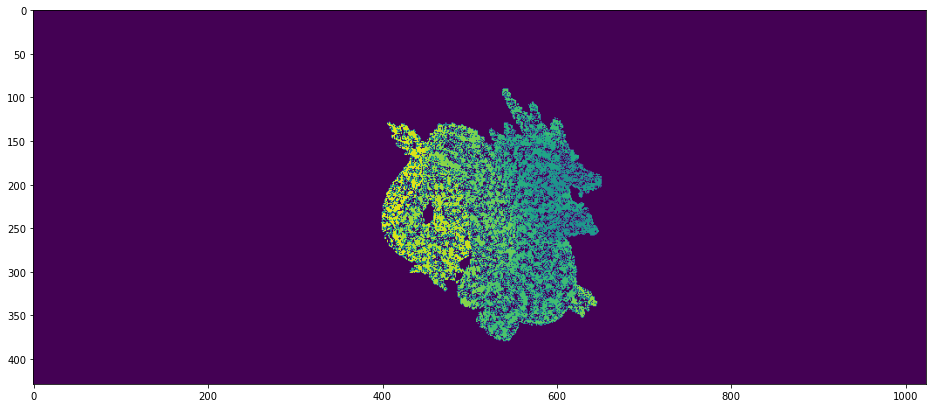

In [7]:
valid = sign_dist_nn(start, norm, travel) < 0.1
image = travel.copy()
image += image[valid].max() - 2.0 * image[valid].min()
image *= valid

plt.figure(figsize=(16,16))
plt.imshow(image)

## Linear Interpolation

The above render glitched because it jumps between the values in the sdf function; the problem is fixed by _interpolating_ between the values. This will make the function smooth enough for it behave sensibly. We can solve this with [linear interpolation](https://en.wikipedia.org/wiki/Linear_interpolation). In 1D on a grid with a step size of $1$, linear interpolation is
```
base = int(x)
t = x - base
value = (1-t) * sdf[base] + t * sdf[int(x)+1]
```

In three dimensions it is called trilinear interpolation, and can be coded as
```
base_x = int(x)
base_y = int(y)
base_z = int(z)
tx = x - base_x
ty = y - base_y
tz = z - base_z

value = 0
for oz in range(2):
  for oy in range(2):
    for ox in range(2):
      weight = 1.0
      if oz==0: weight *= 1 - tz
      else: weight *= tz
      if oy==0: weight *= 1 - ty
      else: weight *= ty
      if ox==0: weight *= 1 - tx
      else: weight *= tx
      value += weight * sdf[base_x+ox, base_y+oy, base_z+oz]
```

Your task is to take the above and write a new version of your sdf evaluation function that includes this. To give complete code, without vectorisation:
```
for v in range(height):
  for u in range(width):
    # Get end of ray...
    pos = start[v,u,:] + travel[v,u] * norm[v,u,:]
    pos += 0.5 * numpy.array(sdf.shape)
    
    # Get base part of coordinate (no 0.5 this time!) and bounds check...
    base = pos.astype(int)
    
    for d in range(3):
      if base[d]<0:
        base[d] = 0
      if base[d]>=sdf.shape[d]-1:
        base[d] = sdf.shape[d] - 2
    
    # Calculate t part of coordinate...
    t = pos - base
    for d in range(3):
      if t[d]<0:
        t[d] = 0
      if t[d]>1:
        t[d] = 1
    
    # Trilinear interpolation...
    ret[v,u] = 0
    for ox in range(2):
      for oy in range(2):
        for oz in range(2):
          weight = 1.0
          if ox==0: weight *= 1 - t[0]
          else: weight *= t[0]
          if oy==0: weight *= 1 - t[1]
          else: weight *= t[1]
          if oz==0: weight *= 1 - t[2]
          else: weight *= t[2]
          
          ret[v,u] += weight * sdf[base[0]+ox, base[1]+oy, base[2]+oz]
```


Hints:
 * When doing the bounds check you will need to go one tighter on the maximum to account for the +1s in the trilinear interpolation loop.
 * Do not let the `t` values go outside of `0..1` as the system may explode; a straightforward solution is to use [`numpy.clip(t, 0, 1)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html) to limit the `t` values.

__(6 marks)__
 * You will lose marks for looping over pixels, but not for looping over the terms in trilinear interpolation (`ox` etc. above) or dimensions. Same principle as before - it's only worth vectorising loops that go around 100s of times.

In [11]:
def sign_dist_linear(start, norm, travel):
    """Given three arrays this returns how far each ray is from the closest point
    on the surface (allowed to be an underestimate if outside the sdf volume).
    Input (pos = (height, width, 3) array of starting positions,
    norm = (height, width, 3) array of directions of travel,
    travel = (height, width) array of how far each ray has travelled.);
    Output = (height, width) array of how far the end of each ray is from the surface, signed."""
    
    # **************************************************************** (6 marks)
    ret = numpy.zeros(start.shape[:2])

    pos = start[::] + travel[:,:,None] * norm[::]
   
    pos += ( 0.5 * numpy.array(sdf.shape))
    
    base = pos.astype(int)
    
    for d in range(3) :
        base[:,:,d][base[:,:,d] < 0] = 0
        base[:,:,d][base[:,:,d] >= sdf.shape[d] -1] = sdf.shape[d] - 2
        
        
    t = pos - base
    
    
    for d in range(3) :
        t[:,:,d][t[:,:,d] < 0] = 0
        t[:,:,d][t[:,:,d] > 1] = 1
        
        
    for ox in range(2):
        for oy in range(2):
            for oz in range(2):
                weight = 1.0
                if ox==0: weight *= 1 - t[:,:,0]
                else: weight *= t[:,:,0]
                if oy==0: weight *= 1 - t[:,:,1]
                else: weight *= t[:,:,1]
                if oz==0: weight *= 1 - t[:,:,2]
                else: weight *= t[:,:,2]

                ret[:,:] += weight * sdf[base[:,:,0]+ox, base[:,:,1]+oy, base[:,:,2]+oz]

    return ret
        
        
        


    
    

    


# Fire!..
better_travel = numpy.zeros((height, width))
for _ in range(max(sdf.shape)):
    better_travel += sign_dist_linear(start, norm, better_travel)
    better_travel[better_travel>1e6] = 1e6 # Safety

## Visualisation

Same as before, but if you got your function right the glitches should be fixed.

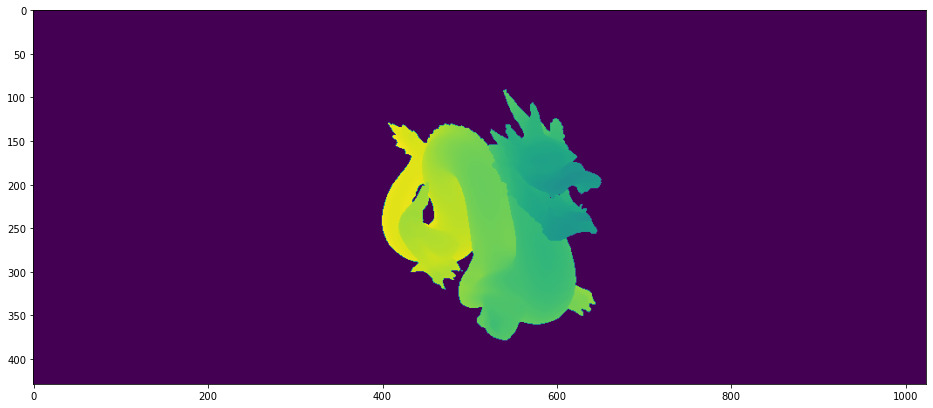

In [12]:
valid = sign_dist_linear(start, norm, better_travel) < 0.1
image = better_travel.copy()
image += image[valid].max() - 2.0 * image[valid].min()
image *= valid

plt.figure(figsize=(16,16))
plt.imshow(image)

## Lambertian Shading

(This is optional, and confers no marks. An extra challenge for those who want it.)

Rendering depth is pretty dull; it looks much better if we shade the surface. The simplest shading is the _Lambertian reflectance model_; whilst simple it actually looks pretty good. The equation is:
```
brightness = max(normal.dot(light), 0)
```
where normal is the surface normal of the model and light is a unit vector pointing at the light source. You can select any light vector you want. The normal is the gradient of the sdf, which will need to be scaled to have unit length.

Your challenge, if you choose to accept it, is to rewrite the visualisation code to shade the surface.